In [125]:
import numpy as np
import pandas as pd
import optuna
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

# Загрузим данные

- Данные упорядочены по времени
- Задача - предсказать `target`
- Фичи - `feature_i`
- Трейн, валидация и тест уже определены (см. колонку `sample_part`)

In [126]:
df = pd.read_parquet('df.parquet.gzip')
df.info()

<class 'pandas.DataFrame'>
Index: 500000 entries, 22620 to 310653
Columns: 235 entries, date to sample_part
dtypes: category(2), datetime64[ms](1), datetime64[ns](2), float64(220), int64(9), str(1)
memory usage: 895.6 MB


In [127]:
df.head()

date      month    quarter  feature_217  feature_66  feature_9  \
22620  2021-01-01 2021-01-01 2021-01-01     1.180855    0.483118  13.976791   
478621 2021-01-01 2021-01-01 2021-01-01     3.427814    0.886778  27.158209   
372254 2021-01-01 2021-01-01 2021-01-01   -38.555018    1.227175  19.893873   
2596   2021-01-01 2021-01-01 2021-01-01   -14.666558    0.753129  18.203010   
216892 2021-01-01 2021-01-01 2021-01-01     6.734990    1.129100  11.245920   

        feature_193  feature_15  feature_199  feature_25  ...  feature_20  \
22620      1.135021   43.271792   -46.888875   97.558366  ...   23.745198   
478621    -0.378728   80.087863   -67.242703  105.803406  ...   22.902111   
372254     0.498787   98.464365   -67.402522   81.858076  ...   21.848414   
2596      -1.200014  117.331340   -25.557745   90.277266  ...   26.134586   
216892    -0.108955   61.205722   -78.397406   82.637472  ...   24.201039   

        feature_188  feature_71  feature_106  feature_14  feature_92  \
22620    -32.001093   85.489903     1.454045 -195.725786    3.719083   
478621   -37.436243   71.735619     1.657242 -176.250404    3.277817   
372254   -51.872841   65.363236     1.626874 -178.116798    2.028950   
2596     -49.703003   65.013659     1.170023 -192.232264    2.218177   
216892   -41.070219   69.986127     1.630795 -200.155528    3.055104   

        feature_179  feature_102  target  sample_part  
22620             1   -28.813537     0.0        train  
478621            1   -45.987721     1.0        train  
372254            0   -31.074122     1.0        train  
2596              1   -36.703897     0.0        train  
216892            1   -44.672299     1.0        train  

[5 rows x 235 columns]

In [128]:
TARGET = 'target'
N_FEATURES = 230
features = [f'feature_{i}' for i in range(N_FEATURES)]

# Первичный отбор признаков... (1 балл)

**Задание:** Сначала отсеем совсем уж мусорные признаки.

Воспользовавшись вашим кодом для вычисления `IV` из прошлой домашки, для всех **числовых** фичей вычислите `IV` на 20 бакетах. Отсейте признаки с `IV < 0.005`.

**Hint:** паркет не всегда сохраняет `dtype` колонки. Чтобы проверить признаки на "реальный" тип данных, лучше на всякий случай посмотреть на `nunique` 

In [129]:
from scipy.special import logit
import scipy.stats as sps

def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

def calc_buckets_with_nan_bucket(x: Union[np.ndarray, pd.Series], n_buckets: int) -> np.ndarray:
    """Разбивает на бакеты, выделяя отдельный бакет для NaN"""
    
    x = pd.Series(x).reset_index(drop=True)
    buckets = pd.Series(np.full(len(x), -1), dtype=np.int16)  # -1 для NaN
    
    # Только не-NaN значения
    mask = x.notna()
    if mask.any():
        x_valid = x[mask]
        valid_buckets = x_valid.rank(method="dense", pct=True) * n_buckets
        valid_buckets = np.ceil(valid_buckets) - 1
        buckets[mask] = valid_buckets.astype(np.int16)
    
    return buckets.values

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    woe = logit(badrate) - offset
    return woe

def ci_wilson(k, n, confidence=0.95):
    
    p_hat = k / n
    z = sps.norm.ppf(1 - (1 - confidence)/2)
    denominator = 1 + (z**2) / n
    center = p_hat + z**2 / (2 * n)
    half_width = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2))
    
    lower = np.maximum(0, (center - half_width) / denominator)
    upper = np.minimum(1, (center + half_width) / denominator)
    
    return lower, upper

def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""

    df = pd.DataFrame({'target': target, 'bucket': buckets})
    grouped = df.groupby('bucket')['target']

    counts = grouped.count()  # n_i
    sums = grouped.sum() 
    # считаем бэдрейт и доверительный интервал для него (любым способом)

    badrate = sums / counts
    badrate_lower, badrate_upper = ci_wilson(sums, counts)

    # переходим от бэдрейта к woe
    
    woe = woe_transform(badrate, offset)
    woe_lower = woe_transform(badrate_lower, offset)
    woe_upper = woe_transform(badrate_upper, offset)

    return woe, woe_lower, woe_upper

def calc_IV(
        model_values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray,
        offset : np.float64, 
    ):
    """Считает для признака roc auc, IV, R^2"""
    
    

    df_temp = pd.DataFrame({
        'value': model_values,
        'target': target,
        'bucket': buckets
    })

    grouped = df_temp.groupby('bucket').agg({
        'target': ['count', 'sum'],  # всего наблюдений и "плохих"
        'value': 'mean'  # среднее значение признака в бакете
    })
    

    # формула выше
    woe, _, _ = woe_ci(target, buckets, offset)
    woe = woe.loc[grouped.index]
    total_bad = grouped[('target', 'sum')].sum()
    total_good = grouped[('target', 'count')].sum() - total_bad

    dist_bad = grouped[('target', 'sum')] / total_bad
    dist_good = (grouped[('target', 'count')] - grouped[('target', 'sum')]) / total_good

    IV = np.sum((dist_bad - dist_good) * woe) 

    return IV

In [130]:
print(df.isnull().sum()[df.isnull().sum() > 1])

feature_223     73488
feature_30      34475
feature_16      40811
feature_124     58984
feature_10     166667
                ...  
feature_87      31645
feature_202     46042
feature_74      28919
feature_214     43601
feature_210     32347
Length: 68, dtype: int64


In [131]:
print(df["feature_210"].isnull().sum())


32347


In [133]:
good_numeric_features = []
overall_badrate = df[TARGET].mean()
offset = logit(overall_badrate)
nunique = df.nunique()
N_BUCKETS = 20

numeric_features = [
    col for col in features
    if nunique[col] > N_BUCKETS
]

iv_values = {}

for feature in numeric_features:
    x = df[feature].values

    buckets = calc_buckets_with_nan_bucket(x, n_buckets=N_BUCKETS)
    
    iv = calc_IV(
        model_values= df[feature].values,
        target=df[TARGET].values,
        buckets=buckets,
        offset=offset
    )
    iv_values[feature] = iv

iv_df = (
    pd.Series(iv_values, name='IV')
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={'index': 'feature'})
)


iv_df_filtered = iv_df[iv_df['IV'] >= 0.005]

selected_features_numeric = iv_df_filtered['feature'].tolist()

In [134]:
print(selected_features_numeric)

['feature_44', 'feature_124', 'feature_117', 'feature_30', 'feature_114', 'feature_2', 'feature_227', 'feature_98', 'feature_109', 'feature_172', 'feature_35', 'feature_46', 'feature_43', 'feature_15', 'feature_79', 'feature_218', 'feature_76', 'feature_225', 'feature_24', 'feature_162', 'feature_27', 'feature_167', 'feature_4', 'feature_96', 'feature_75', 'feature_140', 'feature_223', 'feature_139', 'feature_164', 'feature_111', 'feature_56', 'feature_38', 'feature_183', 'feature_70', 'feature_36', 'feature_94', 'feature_115', 'feature_132', 'feature_39', 'feature_100', 'feature_97', 'feature_206', 'feature_12', 'feature_9', 'feature_213', 'feature_155', 'feature_23', 'feature_32', 'feature_170', 'feature_135', 'feature_154', 'feature_142', 'feature_26', 'feature_5']


**Вопрос**: Почему некорректно сравнивать `IV` у категориальных и числовых фичей? потому что категориальные фичи уже имеют естественные "бины". Если категорий много IV может быть завышен. 

Вычислите IV для категориальных фичей на `n` бакетах, где `n = min(число категорий фичи, 20)`. Возможно, придётся перекодировать некоторые фичи (*только не OneHot-ом!*)

*Опционально*: примените также и к категориальным фичам предварительный отбор по `IV` с менее строгим порогом

In [135]:
from sklearn.preprocessing import TargetEncoder
cat_features = [
        col for col in features
        if nunique[col] < 50
    ]

def process_categorical_features(df, cat_features, target, offset):
    target_encoder = TargetEncoder()

    iv_values = {}

    for feature in cat_features:
        
        encoded_feature = target_encoder.fit_transform(df[[feature]], target).ravel()

        n = min(df[feature].nunique(), 20)

        buckets = calc_buckets_with_nan_bucket(encoded_feature, n_buckets=n)
        
        iv = calc_IV(
            model_values= encoded_feature,
            target=target.values,
            buckets=buckets,
            offset=offset
        )
        iv_values[feature] = iv
    return iv_values


iv_values = process_categorical_features(df, cat_features, df[TARGET], offset)

iv_cat_df = (
    pd.Series(iv_values, name='IV')
      .sort_values(ascending=False)
      .reset_index()
      .rename(columns={'index': 'feature'})
)

print(iv_cat_df)
iv_df_filtered_cat = iv_cat_df[iv_cat_df['IV'] >= 0.001]

selected_cat_features = iv_df_filtered_cat['feature'].tolist()
print(selected_cat_features)

        feature        IV
0   feature_209  0.025195
1   feature_144  0.013361
2    feature_31  0.012374
3   feature_165  0.009136
4   feature_147  0.007958
5    feature_10  0.007246
6   feature_168  0.006440
7    feature_62  0.006033
8   feature_161  0.001754
9     feature_0  0.000836
10   feature_37  0.000163
11  feature_157  0.000097
12  feature_179  0.000030
13  feature_222  0.000015
['feature_209', 'feature_144', 'feature_31', 'feature_165', 'feature_147', 'feature_10', 'feature_168', 'feature_62', 'feature_161']


# Бустинг

## Подбор гиперпараметров бустинга (3 балла)

Теперь подберем оптимальные гиперпараметры бустинга.

In [ ]:
# В переменную features_optuna положите список признаков с предыдущего шага
features_optuna = selected_features_numeric + selected_cat_features

**Задание:** Заполните пропуски в коде ниже и подберите оптимальные гиперпараметры.

Для успешного решения необходимо преодолеть порог ROC-AUC `0.725` на тестовой выборке.

In [ ]:
'''
def objective(trial):
    params = {
    'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, log=True),  
    'num_leaves': trial.suggest_int('num_leaves', 30, 50),  
    'max_depth': trial.suggest_int('max_depth', 6, 8),  
    'subsample': trial.suggest_float('subsample', 0.8, 1.0),
    'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),  
    'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True),  
    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
    'random_state': 42
}
    
    clf = LGBMClassifier(**params)
    clf.fit(
        X=df.loc[df['sample_part'] == 'train', features_optuna],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )
    
    return auc_valid
'''

"\ndef objective(trial):\n    params = {\n    'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, log=True),  \n    'num_leaves': trial.suggest_int('num_leaves', 30, 50),  \n    'max_depth': trial.suggest_int('max_depth', 6, 8),  \n    'subsample': trial.suggest_float('subsample', 0.8, 1.0),\n    'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),  \n    'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True),  \n    'n_estimators': trial.suggest_int('n_estimators', 100, 500),\n    'random_state': 42\n}\n\n    clf = LGBMClassifier(**params)\n    clf.fit(\n        X=df.loc[df['sample_part'] == 'train', features_optuna],\n        y=df.loc[df['sample_part'] == 'train', TARGET]\n    )\n    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]\n    auc_valid = roc_auc_score(\n        y_true=df.loc[df['sample_part'] == 'val', TARGET],\n        y_score=preds\n    )\n\n    return auc_valid\n"

In [ ]:
'''
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
'''


"\nstudy = optuna.create_study(direction='maximize')\nstudy.optimize(objective, n_trials=50)\n"

In [ ]:
'''best_params = study.best_params
best_auc = study.best_value

print('Best params: ', best_params)
print('Best AUC: ', best_auc)'''

"best_params = study.best_params\nbest_auc = study.best_value\n\nprint('Best params: ', best_params)\nprint('Best AUC: ', best_auc)"

долго искать оптимал эти возьму


In [136]:

best_params = {
    'learning_rate': 0.06992122002910267,
    'num_leaves': 76,
    'max_depth': 7,
    'subsample': 0.8696056800206485,
    'colsample_bytree': 0.902721419082367,
    'reg_alpha': 0.0031140475403417045,
    'reg_lambda': 0.611074407055817,
    'n_estimators': 500,
    'subsample_freq': 5,
    'random_state': 42
}

In [137]:
clf = LGBMClassifier(**best_params)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
assert auc_test > 0.725, f'Необходимое значение ROC-AUC 0.725 и выше, ваше значение: {auc_test}!'

In [138]:
auc_test

0.729324278550849

In [139]:
print(best_params)

{'learning_rate': 0.06992122002910267, 'num_leaves': 76, 'max_depth': 7, 'subsample': 0.8696056800206485, 'colsample_bytree': 0.902721419082367, 'reg_alpha': 0.0031140475403417045, 'reg_lambda': 0.611074407055817, 'n_estimators': 500, 'subsample_freq': 5, 'random_state': 42}


## Кривые накопления (2 балла)

**Задание:** Отрисуйте кривые накопления `ROC AUC` от `n_estimators` для бустинга с гиперпараметрами из предыдущего пункта.

**Hint:** для получения auc на каждой итерации обучения `LGBMClassifier`, можно воспользоваться параметрами `eval_set`, `eval_metric` и в методе `fit`. 

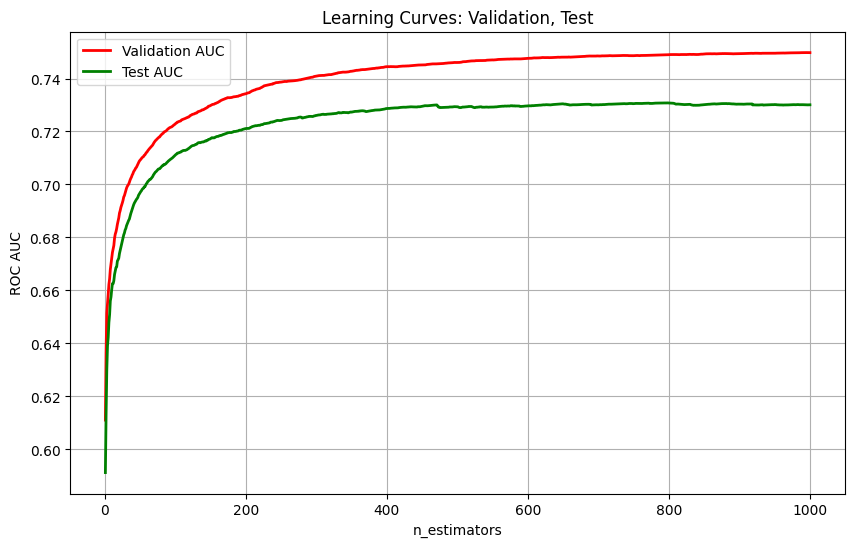

In [140]:
best_params2 = {
    'learning_rate': 0.06992122002910267,
    'num_leaves': 76,
    'max_depth': 7,
    'subsample': 0.8696056800206485,
    'colsample_bytree': 0.902721419082367,
    'reg_alpha': 0.0031140475403417045,
    'reg_lambda': 0.611074407055817,
    'subsample_freq': 5,
    'random_state': 42
}

X_train = df.loc[df['sample_part'] == 'train', features_optuna]
y_train = df.loc[df['sample_part'] == 'train', TARGET]
X_val = df.loc[df['sample_part'] == 'val', features_optuna]
y_val = df.loc[df['sample_part'] == 'val', TARGET]
X_test = df.loc[df['sample_part'] == 'test', features_optuna]
y_test = df.loc[df['sample_part'] == 'test', TARGET]

clf = LGBMClassifier(**best_params2, n_estimators=1000)
clf.fit(
    X_train, y_train,
    eval_set=[
        (X_val, y_val),      
        (X_test, y_test)    
    ],
    eval_metric='auc',
    
)

results = clf.evals_result_

val_auc = results['valid_0']['auc']   
test_auc = results['valid_1']['auc']

# Строим все три кривые
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_auc)+1), val_auc, 'r-', label='Validation AUC', linewidth=2)
plt.plot(range(1, len(test_auc)+1), test_auc, 'g-', label='Test AUC', linewidth=2)

plt.xlabel('n_estimators')
plt.ylabel('ROC AUC')
plt.title('Learning Curves: Validation, Test')
plt.legend()
plt.grid(True)
plt.show()

**Вопрос:** Что вы видите на полученных графиках? 

Нужно ли "обрезать" количество деревьев? Ответ обоснуйте. 

Да нужно, на плато рост незначительный. Для вычислительной эффективности и модель может переобучится. 

## Важность признаков (1 балл)

**Задание:** Постойте гистограмму важности признаков по `split` и `gain` для бустинга из предыдущего пункта.

In [141]:
clf = LGBMClassifier(**best_params)
clf.fit(
    X=X_train,
    y=y_train
)

LGBMClassifier(colsample_bytree=0.902721419082367,
               learning_rate=0.06992122002910267, max_depth=7, n_estimators=500,
               num_leaves=76, random_state=42, reg_alpha=0.0031140475403417045,
               reg_lambda=0.611074407055817, subsample=0.8696056800206485,
               subsample_freq=5)

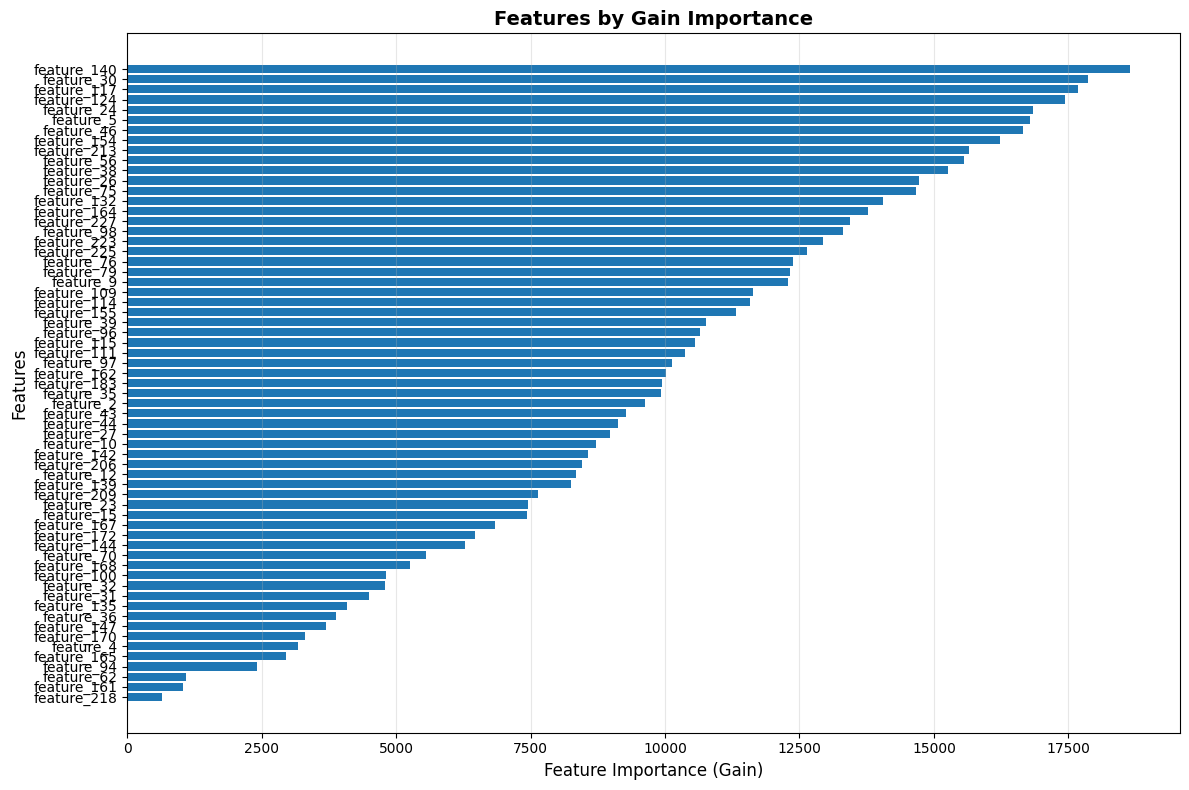

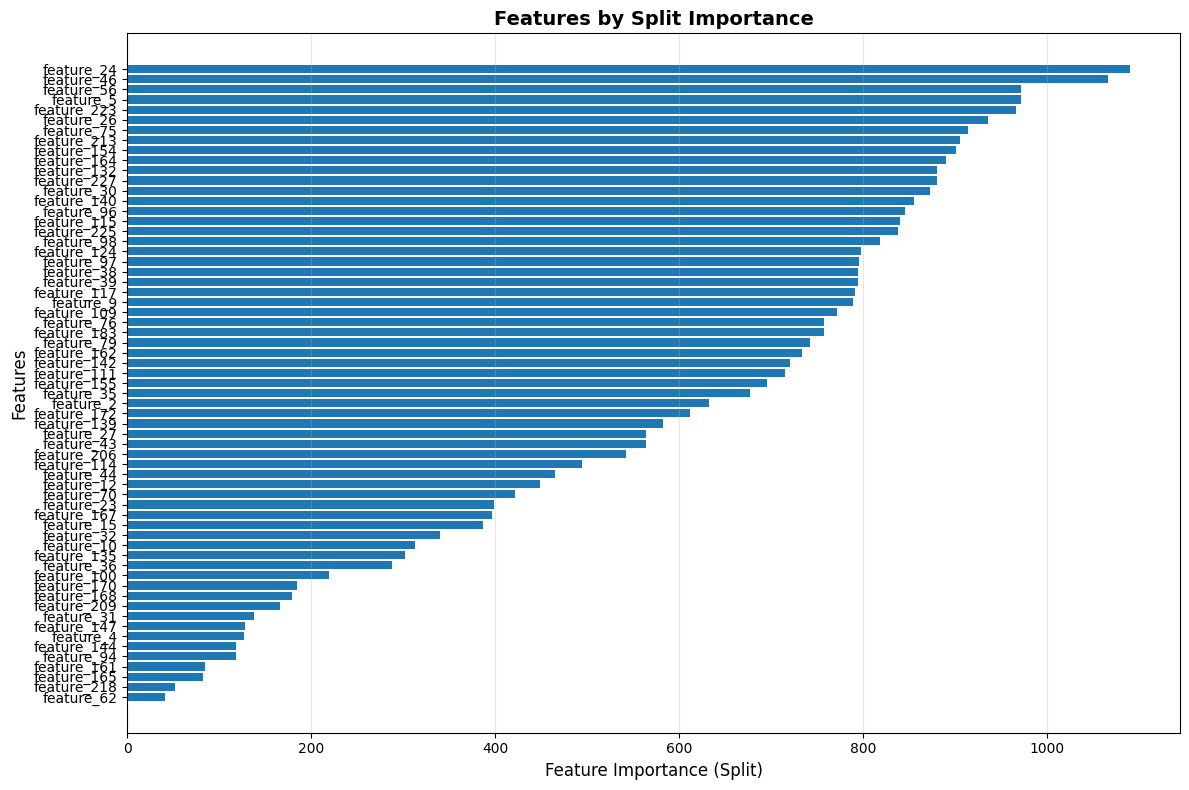

In [142]:
import matplotlib.pyplot as plt

booster = clf.booster_

importance_gain = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance': booster.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

importance_split = pd.DataFrame({
    'feature': booster.feature_name(),
    'importance': booster.feature_importance(importance_type='split')
}).sort_values('importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(importance_gain['feature'][::-1],  
         importance_gain['importance'][::-1])
plt.xlabel('Feature Importance (Gain)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Features by Gain Importance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.barh(importance_split['feature'][::-1],
            importance_split['importance'][::-1])
plt.xlabel('Feature Importance (Split)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Features by Split Importance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

**Вопрос:** Какие выводы можно сделать из полученных графиков?

по сплиту и gain фичи такие же +- в топе, но немного отличается ранжирование

# Логрег

## plot_metric_time (1 балл)

**Задание:** Реализуйте функцию plot_metric_time, которая будет принимать на вход четыре аргумента, а именно: 
- массив значений фичи, 
- массив значений таргета,
- массив времени (аггрегированного по месяцам или кварталам, то есть `month` или `quarter` в вашей задаче, по дням рисовать не надо),
- метрику, которую необходимо отрисовать (нужно реализовать функцию для двух метрик: `IV` и `roc_auc`)
- число бакетов для вычисления `IV`, если выбрана эта метрика

Можете добваить какие-то ещё аргументы, если вам нужно

Если в фиче есть пропуски, функция должна убирать строки с пропусками из рассмотрения

**Hint**: можно, конечно, реализовать эту функцию через цикл, а можно попробовать разобраться и реализовать её через пандасовские `groupby` -> `apply`, это изящнее и быстрее

In [143]:
import plotly.graph_objects as go

In [144]:
def plot_metric_time(
        values: pd.Series,
        target: pd.Series,
        time: pd.Series,
        metric: str = 'IV',
        n_buckets_for_IV: int = 15
) -> go.Figure:
    
    df = pd.DataFrame({
        'values': values,
        'target': target,
        'time': time
    })
    df = df.dropna()
    df.groupby('time')

    def calculate_iv(df_group, n_buckets):
        overall_badrate = df[TARGET].mean()
        offset = logit(overall_badrate)
        buckets = calc_buckets(df_group['values'], n_buckets)
        iv = calc_IV(df_group['values'], df_group['target'], buckets, offset)
        return iv
    
    def calculate_roc_auc(df_group):
        auc_score = roc_auc_score(df_group['target'], df_group['values'])
        return auc_score
    
    if metric == 'IV':
        metric_values = df.groupby('time').apply(calculate_iv, n_buckets = n_buckets_for_IV)
    elif metric == 'roc_auc':
        metric_values = df.groupby('time').apply(calculate_roc_auc)
    else:
        raise NotImplementedError("only 'IV' and 'roc_auc' metrics are implemented")

    plot_title = f'Metric: {metric} по времени'
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x= metric_values.index,
            y= metric_values.values,
            mode='markers+lines',
            name=f'Metric: {metric} по времени'
            ))
    fig.update_layout(
            title_text=plot_title,
            yaxis=dict(title=metric),
            width=1000,
            height=450,
            xaxis=dict(
                domain=[0, .95],
                showgrid=True,
                tickvals=metric_values.index, # месяцы или кварталы, your code here
                ),
            margin=dict(l=30, r=30, b=30, t=50),
            )
    fig.show()


In [145]:
# примерно так это должно будет выглядеть
plot_metric_time(df['feature_1'], df['target'], df['quarter'], metric='roc_auc') # 

**Задание:** Возьмите **топ-15** фичей получившегося бустинга по важности по `gain`. Отрисуйте для них графики стабильности по `IV` во времени и удалите из рассмотрения те признаки, качество которых деградирует

**NB!** Обращайте внимание на масштаб оси *y!* Иногда признак стабильнее, чем кажется)

Если вам это мешает, можете поменять ось *y*, чтобы она начиналась от нуля в прошлом задании.

In [146]:
top15_features_gain = importance_gain['feature'][:15].iloc[::-1]

for feature in top15_features_gain:
    print(feature)
    plot_metric_time(df[feature], df['target'], df['quarter'])


feature_164


feature_132


feature_75


feature_26


feature_38


feature_56


feature_213


feature_154


feature_46


feature_5


feature_24


feature_124


feature_117


feature_30


feature_140


На этом моменте предлагаю сделать новый маленький датафрейм, чтобы не "портить" исходный

И проводить все манипуляции с фичами на нём

In [147]:
features_to_exclude = ['feature_38', 'feature_154', 'feature_5']

top15_features_gain = top15_features_gain[~top15_features_gain.isin(features_to_exclude)]
top15_features_gain_list = top15_features_gain.tolist()

df_for_logreg = df[top15_features_gain_list + ['date', 'month', 'quarter', 'target', 'sample_part']]

## Предобработка признаков (3 балла)

**Задание:** Используя функицю woe_line из предыдущего ДЗ, проверьте **числовые** фичи из полученного списка фичей на линейность по WoE на трейн-выборке (если в фиче есть пропуски - дропаем их при отрисовке)

Если фичи нелинейные, **линеаризуйте их**.

Преобразования, которые можно/стоит пробовать:
- клипы (`np.clip`) - зачастую их достаточно
- корень
- квадрат
- логарифм

Если нужно, можно прибавлять к фиче константу или менять её знак

При желании можно "распилить фичу на две половины" (если она немонотонна) и линеаризовать их по отдельности

Однако слишком упираться в линеаризацию фичей не нужно. Если фича ну совсем никак не линеаризуется, в крайнем случае можно её дропнуть или оставить как есть.

При отрисовке можно ограничиться 15-20 бактеами

In [148]:
def ci_wilson(k, n, confidence=0.95):
    
    p_hat = k / n
    z = sps.norm.ppf(1 - (1 - confidence)/2)
    denominator = 1 + (z**2) / n
    center = p_hat + z**2 / (2 * n)
    half_width = z * np.sqrt(p_hat * (1 - p_hat) / n + z**2 / (4 * n**2))
    
    lower = np.maximum(0, (center - half_width) / denominator)
    upper = np.minimum(1, (center + half_width) / denominator)
    
    return lower, upper

def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""

    df = pd.DataFrame({'target': target, 'bucket': buckets})
    grouped = df.groupby('bucket')['target']

    counts = grouped.count()  # n_i
    sums = grouped.sum() 
    # считаем бэдрейт и доверительный интервал для него (любым способом)

    badrate = sums / counts
    badrate_lower, badrate_upper = ci_wilson(sums, counts)

    # переходим от бэдрейта к woe
    
    woe = woe_transform(badrate, offset)
    woe_lower = woe_transform(badrate_lower, offset)
    woe_upper = woe_transform(badrate_upper, offset)

    return woe, woe_lower, woe_upper

from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""

    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    log_reg = LogisticRegression()
    log_reg.fit(values.reshape(-1, 1), target)

    X_mean = mean_feature.values.reshape(-1, 1)
    proba = log_reg.predict_proba(X_mean)[:, 1]
    line = woe_transform(proba, offset)
    return line

def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""
    
    overall_badrate = target.mean()
    offset = logit(overall_badrate)

    df = pd.DataFrame({
    "value": values,
    "bucket": buckets
    })

    mean_feature = df.groupby("bucket")["value"].mean()
    
    line = calc_line(values, target, mean_feature, offset)
    woe, woe_lower, woe_upper = woe_ci(target, buckets, offset)

    buckets_info = {
        "mean_feature" : mean_feature,
        "line"         : line,
        "woe"          : woe,
        "woe_lower"    : woe_lower,
        "woe_upper"    : woe_upper
    }

    return buckets_info

from sklearn.metrics import roc_auc_score

def calc_plot_title(
        model_values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    
    auc = roc_auc_score(target, model_values)

    df_temp = pd.DataFrame({
        'value': model_values,
        'target': target,
        'bucket': buckets
    })

    grouped = df_temp.groupby('bucket').agg({
        'target': ['count', 'sum'],  # всего наблюдений и "плохих"
        'value': 'mean'  # среднее значение признака в бакете
    })
    

    # формула выше
    woe, _, _ = woe_ci(target, buckets, offset)
    woe = woe.loc[grouped.index]
    total_bad = grouped[('target', 'sum')].sum()
    total_good = grouped[('target', 'count')].sum() - total_bad

    dist_bad = grouped[('target', 'sum')] / total_bad
    dist_good = (grouped[('target', 'count')] - grouped[('target', 'sum')]) / total_good

    IV = np.sum((dist_bad - dist_good) * woe)


    # Взвешенный R^2 
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете


    X = grouped[('value', 'mean')].values
    Y = woe.values
    weights = grouped[('target', 'count')].values
    
    # 1. Взвешенная линейная регрессия
    # Используем polyfit с весами
    coeffs = np.polyfit(X, Y, 1, w=weights)  # [slope, intercept]
    
    # 2. Предсказания
    y_pred = coeffs[0] * X + coeffs[1]
    
    # 3. Взвешенный R²
    weighted_mean_y = np.average(Y, weights=weights)
    
    ss_total = np.sum(weights * (Y - weighted_mean_y) ** 2)
    ss_residual = np.sum(weights * (Y - y_pred) ** 2)
    
    R_sqr = 1 - (ss_residual / ss_total) if ss_total != 0 else 0

    plot_title = (        
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

In [ ]:
'''
top15_features_set = set(top15_features_gain.tolist())
numeric_features_set = set(numeric_features)
intersection_features = numeric_features_set.intersection(top15_features_set)
print(intersection_features)
'''
#фичи все числовые оказались

'\ntop15_features_set = set(top15_features_gain.tolist())\nnumeric_features_set = set(numeric_features)\nintersection_features = numeric_features_set.intersection(top15_features_set)\nprint(intersection_features)\n'

In [149]:
for feature in top15_features_gain:
    df_temp = pd.DataFrame({
        'values': df_for_logreg[feature],
        'target': df_for_logreg['target'],
    })
    df_temp.dropna(inplace=True)
    print(feature)
    woe_line(values=df_temp['values'].values, target=df_temp['target'].values, n_buckets=15).show()

feature_164


feature_132


feature_75


feature_26


feature_56


feature_213


feature_46


feature_24


feature_124


feature_117


feature_30


feature_140


In [150]:
def robust_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

def squared(x):
    return np.square(x)


def signed_sqrt(x):
    return np.sign(x) * np.sqrt(np.abs(x))

In [151]:
df_temp = pd.DataFrame({
        'values': df_for_logreg['feature_164'],
        'target': df_for_logreg['target'],
    })
df_temp.dropna(inplace=True)
print('feature_164')
woe_line(values=squared(df_temp['values'].values), 
         target=df_temp['target'].values, 
         n_buckets=15).show()

df_for_logreg['feature_164'] = squared(df_for_logreg['feature_164'])

feature_164


In [152]:
df_temp = pd.DataFrame({
        'values': df_for_logreg['feature_132'],
        'target': df_for_logreg['target'],
    })
df_temp.dropna(inplace=True)
print('feature_132')
woe_line(values=squared(df_temp['values'].values), 
         target=df_temp['target'].values, 
         n_buckets=15).show()

df_for_logreg['feature_132'] = squared(df_for_logreg['feature_132'])

feature_132


In [153]:
df_temp = pd.DataFrame({
        'values': df_for_logreg['feature_56'],
        'target': df_for_logreg['target'],
    })
df_temp.dropna(inplace=True)
print('feature_56')
woe_line(values= squared(df_temp['values'].values), 
         target=df_temp['target'].values, 
         n_buckets=15).show()

df_for_logreg['feature_56'] = squared(df_for_logreg['feature_56'])

feature_56


In [154]:
df_temp = pd.DataFrame({
        'values': df_for_logreg['feature_213'],
        'target': df_for_logreg['target'],
    })
df_temp.dropna(inplace=True)
print('feature_213')
woe_line(values= robust_transform(df_temp['values'].values.clip(min = 9, max=14)), 
         target=df_temp['target'].values, 
         n_buckets=15).show()

df_for_logreg['feature_213'] = robust_transform(df_for_logreg['feature_213'].values.clip(min = 9, max=14))

feature_213


In [155]:
df_temp = pd.DataFrame({
        'values': df_for_logreg['feature_46'],
        'target': df_for_logreg['target'],
    })
df_temp.dropna(inplace=True)
print('feature_46')
woe_line(values= squared(df_temp['values'].values), 
         target=df_temp['target'].values, 
         n_buckets=15).show()

df_for_logreg['feature_46'] = squared(df_for_logreg['feature_46'])

feature_46


In [156]:
df_temp = pd.DataFrame({
        'values': df_for_logreg['feature_124'],
        'target': df_for_logreg['target'],
    })
df_temp.dropna(inplace=True)
print('feature_124')
woe_line(values= df_temp['values'].values.clip(min = -60, max = -32), 
         target=df_temp['target'].values, 
         n_buckets=15).show()
df_for_logreg['feature_124'] = df_for_logreg['feature_124'].values.clip(min = -60, max = -32)

feature_124


In [157]:
df_temp = pd.DataFrame({
        'values': df_for_logreg['feature_30'],
        'target': df_for_logreg['target'],
    })
df_temp.dropna(inplace=True)
print('feature_30')
woe_line(values= signed_sqrt(df_temp['values'].values), 
         target=df_temp['target'].values, 
         n_buckets=15).show()

df_for_logreg['feature_30'] = signed_sqrt(df_for_logreg['feature_30']) 

feature_30


In [158]:
df_temp = pd.DataFrame({
        'values': df_for_logreg['feature_140'],
        'target': df_for_logreg['target'],
    })
df_temp.dropna(inplace=True)
print('feature_140')
woe_line(values= (df_temp['values'].values.clip(min=12, max =46)), 
         target=df_temp['target'].values, 
         n_buckets=15).show()

df_for_logreg['feature_140'] = df_for_logreg['feature_140'].values.clip(min = 12, max = 46)

feature_140


In [ ]:
'''df_temp = pd.DataFrame({
        'values': df_for_logreg['feature_5'],
        'target': df_for_logreg['target'],
    })
df_temp.dropna(inplace=True)
print('feature_5')
woe_line(values= robust_transform((df_temp['values'].values).clip(min=-190)), 
         target=df_temp['target'].values, 
         n_buckets=15).show()

df_for_logreg['feature_5'] = robust_transform(df_for_logreg['feature_5'].values.clip(min=-190))'''

"df_temp = pd.DataFrame({\n        'values': df_for_logreg['feature_5'],\n        'target': df_for_logreg['target'],\n    })\ndf_temp.dropna(inplace=True)\nprint('feature_5')\nwoe_line(values= robust_transform((df_temp['values'].values).clip(min=-190)), \n         target=df_temp['target'].values, \n         n_buckets=15).show()\n\ndf_for_logreg['feature_5'] = robust_transform(df_for_logreg['feature_5'].values.clip(min=-190))"

Пришло время заполнить пропуски.

Самый простой вариант для числовых признаков - заполнить их средним значением фичи

**Вопрос**: какие проблемы могут возникнуть при таком заполнении пропусков? 

смещение оценок, снижение дисперсии, пропуск может быть информативен тоже. Не устойчиво к выбросам. 

**Задание**: Проверьте, что заполнение средним значением адекватно для тех признаков, где есть пропуски (hint: в нашем датасете - почти всегда адекватно). Если нет, придумайте, как ещё можно заполнить пропуски. Ну и заполните их) Медиана 

In [159]:
train_mask = df_for_logreg['sample_part'] == 'train'
train_means = df_for_logreg.loc[train_mask, top15_features_gain].mean()

df_for_logreg[top15_features_gain] = df_for_logreg[top15_features_gain].fillna(train_means)
df_for_logreg

feature_164   feature_132  feature_75  feature_26     feature_56  \
22620     6959.607487   2604.673317  -37.566036   45.123716   66938.530157   
478621   37195.309591    166.337140  -51.686117   33.405854    5644.711085   
372254   12514.464752   1784.053056  -32.603922 -186.825975   72968.844227   
2596      7614.033948    445.117938  -45.032987  -74.749292  214825.088060   
216892    3129.880295    480.783012  -58.049155  186.120862  107045.493786   
...               ...           ...         ...         ...            ...   
196513   12998.548446      2.186307  -38.487619  117.733537     581.941113   
108604  109755.475778    127.167807  -58.078548 -105.240386   23120.444309   
141359   12189.867442  21039.389165  -35.814129   34.557879    1310.039113   
443018   28769.693369  48407.784244  -27.440006   62.964368    1724.241858   
310653    5933.179774    191.601761  -58.961194  -65.784454    8683.021708   

        feature_213    feature_46  feature_24  feature_124  feature_117  \
22620      2.302585  13298.619457   -7.179830   -60.000000   -17.226707   
478621     2.475238  29922.502709  -23.797875   -32.000000    -8.564242   
372254     2.708050  14299.434373  -22.976857   -42.930140   -10.249472   
2596       2.708050   7226.614864  -14.087877   -42.117574   -13.114987   
216892     2.302585   1858.367738  -17.195954   -48.599477    -7.378194   
...             ...           ...         ...          ...          ...   
196513     2.302585  71232.900268   -1.997241   -34.698016   -13.148536   
108604     2.708050    909.953981  -11.417951   -57.378146   -18.802413   
141359     2.617596  68005.765119  -32.527420   -46.912357   -11.941628   
443018     2.437442     10.851632   -3.723810   -32.000000   -12.865323   
310653     2.708050  16350.957377  -18.952444   -42.930140   -11.315535   

        feature_30  feature_140       date      month    quarter  target  \
22620     0.191655    15.000000 2021-01-01 2021-01-01 2021-01-01     0.0   
478621    0.244044    28.000000 2021-01-01 2021-01-01 2021-01-01     1.0   
372254    0.289116    12.000000 2021-01-01 2021-01-01 2021-01-01     1.0   
2596      0.144942    22.000000 2021-01-01 2021-01-01 2021-01-01     0.0   
216892    0.300566    46.000000 2021-01-01 2021-01-01 2021-01-01     1.0   
...            ...          ...        ...        ...        ...     ...   
196513    0.157614    23.000000 2022-12-30 2022-12-01 2022-10-01     1.0   
108604    0.101199    46.000000 2022-12-30 2022-12-01 2022-10-01     1.0   
141359    0.115563    46.000000 2022-12-30 2022-12-01 2022-10-01     0.0   
443018    0.207509    26.000000 2022-12-30 2022-12-01 2022-10-01     1.0   
310653    0.154735    31.097883 2022-12-30 2022-12-01 2022-10-01     1.0   

       sample_part  
22620        train  
478621       train  
372254       train  
2596         train  
216892       train  
...            ...  
196513        test  
108604        test  
141359        test  
443018        test  
310653        test  

[500000 rows x 17 columns]

Вспомним про категориальные признаки, их нужно закодировать.

**Задание:** Используя `OneHotEncoder` закодируйте категориальные признаки.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# your code here

# в датасете df_for_logreg категориальных фич нет, поэтому тут пусто)

## Stepwise и обучение логрега (4 балла)

**Задание (boss)**: Реализуйте Stepwise-алгоритм.

Ваша функция `stepwise` должна принимать на вход:
- Датафрейм со всеми признаками и таргетом
- список с именами рассматриваемых признаков
- строку-имя таргета
- уровни значимости `alpha_in` и `alpha_out`

И возвращать список отобранных признаков.

Во время работы пусть она также выводит, какой признак был включён или исключён и с каким `p-value`

In [ ]:
from scipy.stats.distributions import chi2
from sklearn.metrics import log_loss

In [ ]:
def likelihood_ratio_test(ll_short, ll_long):
    
    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия модели на k переменных
    ll_long — логарифм правдоподобия модели на k+1 переменной

    Returns
    -----
    p-value
    """
    
    lr =  -2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [ ]:

def calculate_likelihood(model, X, y):
    """Вычисляет логарифм правдоподобия"""
    # Получаем вероятности
    proba = model.predict_proba(X)
    
    # Преобразуем y в целые числа для использования в индексации
    y_np = y.values if hasattr(y, 'values') else y
    y_np = y_np.astype(int)  # <-- Важное преобразование!
    
    # proba имеет форму (n_samples, n_classes), берем вероятность правильного класса
    proba_correct = proba[np.arange(len(y_np)), y_np]
    
    # Избегаем проблем с log(0)
    proba_correct = np.clip(proba_correct, 1e-15, 1 - 1e-15)
    
    log_likelihood = np.sum(np.log(proba_correct))
    
    return log_likelihood


def stepwise(
        df: pd.DataFrame, 
        features: list[str], 
        target: str, 
        alpha_in: float = 0.01, 
        alpha_out:  float = 0.05
        ) -> list[str]:
    

    selected_features = list()
    remaining_features = features.copy().tolist()
    converged = False
    while not converged:
        converged = True
        # forward:
        
        if selected_features:

            model_current = LogisticRegression(max_iter=1000, solver='lbfgs')
            model_current.fit(df[selected_features], df[target])
            likelihood_short = calculate_likelihood(model_current, df[selected_features], df[target])
        else:
            likelihood_short = -np.inf


        if (len(selected_features) < len(features)):
            p_values = []
            for feature in remaining_features:
                #включаем признак с минимальным p value < 0,05 (пока есть хотя бы 1 такой)
                model = LogisticRegression(max_iter=1000, solver='lbfgs', C=1.0,)
                model.fit(df[selected_features + [feature]], df[target])
                likeahood_long = calculate_likelihood(model, df[selected_features + [feature]], df[target])
                p_value = likelihood_ratio_test(likelihood_short, likeahood_long)
        
            
                if p_value < alpha_in:
                    p_values.append((feature, p_value))
                
            
            if p_values:
                best_feature, best_p_value = min(p_values, key=lambda x: x[1])
                
                remaining_features.remove(best_feature)
                selected_features.append(best_feature)
                converged = False
                print(f"В модель была добавлена переменная {best_feature}, p-value: {round(best_p_value, 6)}")
            

        # backward
        worst_feature = None
        if (len(selected_features) > 1):
            model_full = LogisticRegression(max_iter=1000, solver='lbfgs', C=1.0)
            model_full.fit(df[selected_features], df[target])
            likelihood_full = calculate_likelihood(
                model_full, 
                df[selected_features], 
                df[target]
            )
            
            
            p_values = []
            # исключаем признаки с макс p value пока есть хотя бы один с больше чем alpha_out
            for feature in selected_features:
                model = LogisticRegression(max_iter=1000, solver='lbfgs', C=1.0)
                new_features = selected_features.copy()
                new_features.remove(feature)
                model.fit(df[new_features], df[target])
                likelihood_minus = calculate_likelihood(model, df[new_features], df[target])
                p_value = likelihood_ratio_test(likelihood_minus, likelihood_full)
                if p_value > alpha_out:
                    p_values.append((feature, p_value))

            if p_values:
                worst_feature, worst_p_value = max(p_values, key=lambda x: x[1])
                selected_features.remove(worst_feature)
                remaining_features.append(worst_feature)
                converged = False
                print(f"Из модели была удалена переменная {worst_feature}, p-value: {round(worst_p_value, 6)}")

    return selected_features

Запустите ваш алгоритм на отобранных фичах со значениями `alpha_in = 0.01`, `alpha_out = 0.02`

Если в степвайз заходят *все переменные*, причём с очень маленькими `p-value` - это неудивительно, ведь вы уже провели серьёзный предварительный отбор фичей.

Чтобы убедиться в коректности работы своего алгоритма, можете попробовать запустить его на каких-нибудь других фичах, откинутых сильно ранее

In [ ]:
top15_features_gain

28    feature_164
37    feature_132
24     feature_75
52     feature_26
30     feature_56
44    feature_213
11     feature_46
18     feature_24
1     feature_124
2     feature_117
3      feature_30
25    feature_140
Name: feature, dtype: str

In [ ]:
from sklearn.preprocessing import StandardScaler
target_col = df_for_logreg['target']


scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_for_logreg[top15_features_gain])


df_scaled = pd.DataFrame(
    features_scaled,  
    columns=top15_features_gain, 
    index=df_for_logreg.index  
)


df_scaled['target'] = target_col
selected_features = stepwise(df_scaled, top15_features_gain, 'target', alpha_in = 0.01, alpha_out = 0.02)

#selected_features = stepwise(df_for_logreg, top15_features_gain, 'target', alpha_in = 0.01, alpha_out = 0.02)

В модель была добавлена переменная feature_164, p-value: 0.0
В модель была добавлена переменная feature_124, p-value: 0.0
В модель была добавлена переменная feature_117, p-value: 0.0
В модель была добавлена переменная feature_30, p-value: 0.0
В модель была добавлена переменная feature_140, p-value: 0.0
В модель была добавлена переменная feature_24, p-value: 0.0
В модель была добавлена переменная feature_132, p-value: 0.0
В модель была добавлена переменная feature_46, p-value: 0.0
В модель была добавлена переменная feature_75, p-value: 0.0
В модель была добавлена переменная feature_213, p-value: 0.0
В модель была добавлена переменная feature_26, p-value: 0.0
В модель была добавлена переменная feature_56, p-value: 0.0


In [ ]:
print(selected_features)

['feature_164', 'feature_124', 'feature_117', 'feature_30', 'feature_140', 'feature_24', 'feature_132', 'feature_46', 'feature_75', 'feature_213', 'feature_26', 'feature_56']


In [ ]:
'''target_col = df['target']


scaler = StandardScaler()
features_scaled2 = scaler.fit_transform(df[numeric_features])


df_scaled2 = pd.DataFrame(
    features_scaled2,  
    columns=numeric_features, 
    index=df.index  
)

df_scaled2[numeric_features] = df_scaled2[numeric_features].fillna(df_scaled2[numeric_features].mean())

df_scaled2['target'] = target_col

selected_features = stepwise(df_scaled2, pd.Series(numeric_features), 'target', alpha_in = 0.01, alpha_out = 0.02)'''

/var/folders/9m/694f26q91vv91hqgk616c7w80000gn/T/ipykernel_84614/382131334.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



В модель была добавлена переменная feature_1, p-value: 0.0
В модель была добавлена переменная feature_2, p-value: 0.0
Из модели была удалена переменная feature_1, p-value: 0.597915
В модель была добавлена переменная feature_4, p-value: 0.0
В модель была добавлена переменная feature_15, p-value: 0.0


KeyboardInterrupt: 

протестил на всем df

**Задание**: На получившемся наборе признаков обучим, наконец, логрег!

Для обучения можно использовать трейн + валидацию вместе, либо просто трейн

*Не забудьте отскалировать фичи*

In [160]:
df_for_logreg

feature_164   feature_132  feature_75  feature_26     feature_56  \
22620     6959.607487   2604.673317  -37.566036   45.123716   66938.530157   
478621   37195.309591    166.337140  -51.686117   33.405854    5644.711085   
372254   12514.464752   1784.053056  -32.603922 -186.825975   72968.844227   
2596      7614.033948    445.117938  -45.032987  -74.749292  214825.088060   
216892    3129.880295    480.783012  -58.049155  186.120862  107045.493786   
...               ...           ...         ...         ...            ...   
196513   12998.548446      2.186307  -38.487619  117.733537     581.941113   
108604  109755.475778    127.167807  -58.078548 -105.240386   23120.444309   
141359   12189.867442  21039.389165  -35.814129   34.557879    1310.039113   
443018   28769.693369  48407.784244  -27.440006   62.964368    1724.241858   
310653    5933.179774    191.601761  -58.961194  -65.784454    8683.021708   

        feature_213    feature_46  feature_24  feature_124  feature_117  \
22620      2.302585  13298.619457   -7.179830   -60.000000   -17.226707   
478621     2.475238  29922.502709  -23.797875   -32.000000    -8.564242   
372254     2.708050  14299.434373  -22.976857   -42.930140   -10.249472   
2596       2.708050   7226.614864  -14.087877   -42.117574   -13.114987   
216892     2.302585   1858.367738  -17.195954   -48.599477    -7.378194   
...             ...           ...         ...          ...          ...   
196513     2.302585  71232.900268   -1.997241   -34.698016   -13.148536   
108604     2.708050    909.953981  -11.417951   -57.378146   -18.802413   
141359     2.617596  68005.765119  -32.527420   -46.912357   -11.941628   
443018     2.437442     10.851632   -3.723810   -32.000000   -12.865323   
310653     2.708050  16350.957377  -18.952444   -42.930140   -11.315535   

        feature_30  feature_140       date      month    quarter  target  \
22620     0.191655    15.000000 2021-01-01 2021-01-01 2021-01-01     0.0   
478621    0.244044    28.000000 2021-01-01 2021-01-01 2021-01-01     1.0   
372254    0.289116    12.000000 2021-01-01 2021-01-01 2021-01-01     1.0   
2596      0.144942    22.000000 2021-01-01 2021-01-01 2021-01-01     0.0   
216892    0.300566    46.000000 2021-01-01 2021-01-01 2021-01-01     1.0   
...            ...          ...        ...        ...        ...     ...   
196513    0.157614    23.000000 2022-12-30 2022-12-01 2022-10-01     1.0   
108604    0.101199    46.000000 2022-12-30 2022-12-01 2022-10-01     1.0   
141359    0.115563    46.000000 2022-12-30 2022-12-01 2022-10-01     0.0   
443018    0.207509    26.000000 2022-12-30 2022-12-01 2022-10-01     1.0   
310653    0.154735    31.097883 2022-12-30 2022-12-01 2022-10-01     1.0   

       sample_part  
22620        train  
478621       train  
372254       train  
2596         train  
216892       train  
...            ...  
196513        test  
108604        test  
141359        test  
443018        test  
310653        test  

[500000 rows x 17 columns]

In [ ]:
from sklearn.preprocessing import StandardScaler # Или другой скейлер
from sklearn.linear_model import LogisticRegression
from scipy.special import logit

In [161]:
scaler = StandardScaler()
features_to_exclude2 = ['']

features_logreg = top15_features_gain[~top15_features_gain.isin(features_to_exclude2)]

target_col = df_for_logreg['target']


df_train_val = df_for_logreg[df_for_logreg['sample_part'].isin(['train', 'val'])]
X_train_val_scaled = scaler.fit_transform(df_train_val[features_logreg])
y_train_val = df_train_val['target']

df_test = df_for_logreg[df_for_logreg['sample_part'] == 'test']
X_test_scaled = scaler.transform(df_test[features_logreg])


logreg = LogisticRegression()
logreg.fit(X_train_val_scaled, y_train_val)

X_all = scaler.transform(df_for_logreg[features_logreg])
df_for_logreg['logreg'] = logreg.predict_proba(X_all)[:, 1]
df_for_logreg['logit_logreg'] = logit(df_for_logreg['logreg'])

y_pred_proba_test = logreg.predict_proba(X_test_scaled)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

y_pred_proba_train = logreg.predict_proba(X_train_val_scaled)[:, 1]
print(f"ROC-AUC на тестовой выборке: {roc_auc_test:.4f}")

ROC-AUC на тестовой выборке: 0.6058


In [162]:
# это следующая по гейну фича
plot_metric_time(df['feature_227'], df['target'], df['quarter'])

In [163]:
df_temp = pd.DataFrame({
        'values': df['feature_227'],
        'target': df['target'],
    })
df_temp.dropna(inplace=True)
print('feature_227')
woe_line(values=squared(df_temp['values'].values), 
         target=df_temp['target'].values, 
         n_buckets=15).show()



feature_227


In [164]:
df_temp = pd.DataFrame({
        'values': df['feature_98'],
        'target': df['target'],
    })
df_temp.dropna(inplace=True)
print('feature_98')
woe_line(values=(df_temp['values'].values), 
         target=df_temp['target'].values, 
         n_buckets=15).show()



feature_98


In [ ]:
'''
df_for_logreg2 = df_for_logreg[top15_features_gain_list + ['date', 'month', 'quarter', 'target', 'sample_part']]
df_for_logreg2['feature_227'] = squared(df['feature_227'])

#df_for_logreg2['feature_223'] = squared(df['feature_223']) бесполезная
df_for_logreg2['feature_98'] = squared(df['feature_98'])

features_list = list(top15_features_gain) + ['feature_98', 'feature_227']

train_mask = df_for_logreg2['sample_part'] == 'train'
df_for_logreg2[features_list] = df_for_logreg[features_list].fillna(df_for_logreg[features_list].mean())

df_for_logreg2
'''

KeyError: "None of [Index(['feature_164feature_98feature_227', 'feature_132feature_98feature_227',\n       'feature_75feature_98feature_227', 'feature_26feature_98feature_227',\n       'feature_56feature_98feature_227', 'feature_213feature_98feature_227',\n       'feature_46feature_98feature_227', 'feature_24feature_98feature_227',\n       'feature_124feature_98feature_227', 'feature_117feature_98feature_227',\n       'feature_30feature_98feature_227', 'feature_140feature_98feature_227'],\n      dtype='str')] are in the [columns]"

In [ ]:
top15_features_gain

28    feature_164
37    feature_132
24     feature_75
52     feature_26
30     feature_56
44    feature_213
11     feature_46
18     feature_24
1     feature_124
2     feature_117
3      feature_30
25    feature_140
Name: feature, dtype: str

In [ ]:
# добавил пару фич вышло 0,609

'''scaler = StandardScaler()
features_to_exclude2 = ['']

features_logreg2 = top15_features_gain[~top15_features_gain.isin(features_to_exclude2)].tolist() + ['feature_227']

target_col = df_for_logreg2['target']


df_train_val = df_for_logreg2[df_for_logreg2['sample_part'].isin(['train', 'val'])]
X_train_val_scaled = scaler.fit_transform(df_train_val[features_logreg2])
y_train_val = df_train_val['target']

df_test = df_for_logreg2[df_for_logreg2['sample_part'] == 'test']
X_test_scaled = scaler.transform(df_test[features_logreg2])


logreg = LogisticRegression()
logreg.fit(X_train_val_scaled, y_train_val)

X_all = scaler.transform(df_for_logreg2[features_logreg2])
df_for_logreg2['logreg'] = logreg.predict_proba(X_all)[:, 1]
df_for_logreg2['logit_logreg'] = logit(df_for_logreg2['logreg'])

y_pred_proba_test = logreg.predict_proba(X_test_scaled)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)

y_pred_proba_train = logreg.predict_proba(X_train_val_scaled)[:, 1]
print(f"ROC-AUC на тестовой выборке: {roc_auc_test:.4f}")'''

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Задание:** Оцените качество получившегося логрега **на тестовой выборке** по метрике `roc_auc`. 

**Ваша задача - побить** `threshold_auc = 0.622`. Если этого сделать ну совсем не получается, попробуйте добавить в модель ещё переменных (но должно получаться :)

**Также:**

- Постройте графики линейности по WoE получившегося логрега на трейне и тестовой выборке (оценивайте линейность для `logit_logreg`, а не для вероятности!)
- Постройте график стабильности `roc_auc` во времени для получившегося логрега

In [165]:
print("График линейности на тренировочной выборке:")
woe_line(logit(y_pred_proba_train), y_train_val.values, n_buckets=15).show()

print("График линейности на тестовой выборке:")
woe_line(logit(y_pred_proba_test), y_test.values, n_buckets=15).show()

График линейности на тренировочной выборке:


График линейности на тестовой выборке:


In [ ]:
plot_metric_time(df_for_logreg['logreg'], df_for_logreg['target'], df_for_logreg['quarter'], metric='roc_auc') # 

**Задание:** Визуализируйте важность фичей полученной линейной модели.

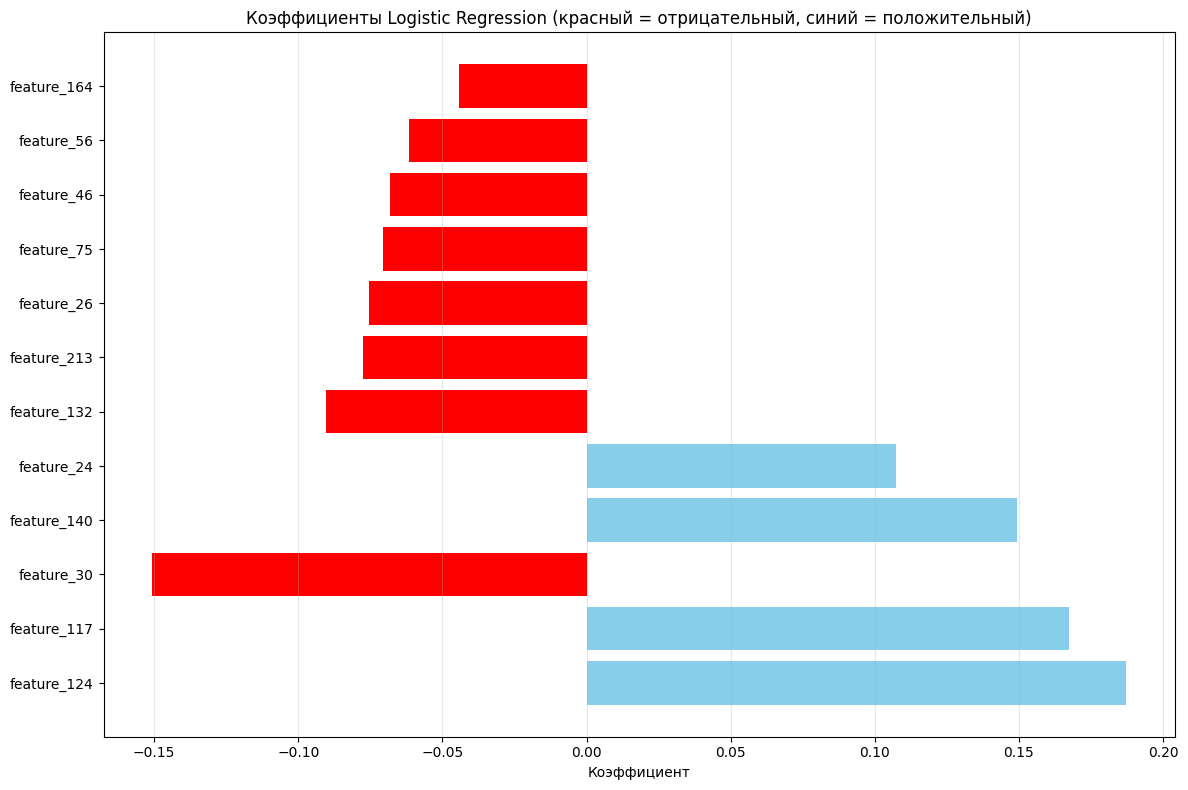

In [ ]:
coefficients = logreg.coef_[0]
feature_names = top15_features_gain


coeff_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# Сортируем по абсолютному значению
coeff_df = coeff_df.sort_values('abs_coefficient', ascending=False)

# Визуализация 1: Барплот коэффициентов
plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'skyblue' for x in coeff_df['coefficient']]
plt.barh(range(len(coeff_df)), coeff_df['coefficient'], color=colors)
plt.yticks(range(len(coeff_df)), coeff_df['feature'])
plt.xlabel('Коэффициент')
plt.title('Коэффициенты Logistic Regression (красный = отрицательный, синий = положительный)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Бонусная часть (до 5 баллов)

В разделе про бустинг мы обучали `LGBMClassifier` на довольно большом наборе фичей. Их количество можно сократить, при этом не теряя в качестве модели.

За начальный набор признаков можно взять все признаки (все 230) или признаки после отбора по IV.

**Ваша задача:** Отобрать признаки, подобрать оптимальные гиперпараметры и обучить `LGBMClassifier`.

Задание творческое) Можно использовать любые методы отбора признаков / оптимизации гиперпараметров.

**Чем меньше признаков, без ухудшения качества модели – тем лучше.**

In [ ]:
unique_features = list(set(features_optuna))
print(f"Признаков: {len(unique_features)}")

Признаков: 63


In [ ]:
from sklearn.preprocessing import TargetEncoder
from sklearn.feature_selection import RFE


best_params = {
    'learning_rate': 0.06992122002910267,
    'num_leaves': 76,
    'max_depth': 7,
    'subsample': 0.8696056800206485,
    'colsample_bytree': 0.902721419082367,
    'reg_alpha': 0.0031140475403417045,
    'reg_lambda': 0.611074407055817,
    'n_estimators': 500,
    'subsample_freq': 5,
    'random_state': 42,
    'verbose': -1
}

df_filled = df[features_optuna + ['date', 'month', 'quarter', 'target', 'sample_part']].copy()
# в нумерик все числовые, но в 

df_filled[selected_features_numeric] = df_filled[selected_features_numeric].fillna(
    df_filled[selected_features_numeric].mean()
)


target_encoder = TargetEncoder(smooth="auto", random_state=42)

train_mask = df_filled['sample_part'] == 'train'


X_train_cat = df_filled.loc[train_mask, selected_cat_features]
target_encoder.fit(X_train_cat, y_train)

df_filled[selected_cat_features] = target_encoder.transform(df_filled[selected_cat_features])
X_train = df_filled.loc[train_mask, features_optuna]
y_train = df_filled.loc[train_mask, TARGET]

clf = LGBMClassifier(**best_params)




#clf.fit(X_train, y_train) необязательно

In [ ]:
X_train

feature_44  feature_124  feature_117  feature_30  feature_114  \
22620    588.375403   -61.495238   -17.226707    0.036732   -37.069315   
478621   832.825671   -28.477404    -8.564242    0.059557   -19.270989   
372254   786.598039   -42.019974   -10.249472    0.083588   -22.636804   
2596    1030.430755   -42.117574   -13.114987    0.021008    -4.883442   
216892  1225.000000   -48.599477    -7.378194    0.090340    14.695917   
...             ...          ...          ...         ...          ...   
409700  1191.669889   -55.250584    -8.584211    0.018083    21.780642   
12274    871.842503   -42.019974   -14.311224    0.029762   -14.003388   
314011  1035.314303   -22.429533    -5.712303    0.186368    -2.101023   
116064  1056.977789   -35.738749    -5.717221    0.009634    -0.523665   
415210   622.412480   -19.605062   -12.647075    0.022658   -32.164143   

        feature_2  feature_227  feature_98  feature_109  feature_172  ...  \
22620   25.846321  -173.334454   15.141825   -20.603835    21.311016  ...   
478621  69.958481  -479.616136   10.567531   -25.523515    75.190560  ...   
372254  77.522873  -222.993621   15.697930   -30.064426    19.341859  ...   
2596     8.587445   312.396421   -5.817810   -37.356662    41.056443  ...   
216892 -55.347640  -201.997489   -7.055506   -38.641177   -54.094720  ...   
...           ...          ...         ...          ...          ...  ...   
409700  20.341671  -103.118559  -14.861374   -33.131357   -47.649048  ...   
12274    8.185631  -538.328022   17.616486   -53.499795    19.341859  ...   
314011  -1.800981  -199.147883  -11.434422   -40.909161   -39.636295  ...   
116064 -32.224977   126.215057  -12.470775   -28.778480    37.578669  ...   
415210  54.276735  -348.152166    6.450067   -27.211333     5.813700  ...   

         feature_5  feature_209  feature_144  feature_31  feature_165  \
22620  -215.945717     0.638637     0.696821    0.668530     0.700603   
478621 -170.713568     0.695487     0.696821    0.723652     0.700603   
372254 -154.503339     0.727655     0.696821    0.723652     0.700603   
2596   -131.553444     0.638637     0.696821    0.723652     0.700603   
216892 -162.092621     0.727655     0.696821    0.723652     0.749818   
...            ...          ...          ...         ...          ...   
409700 -169.482217     0.727655     0.751850    0.723652     0.749818   
12274  -245.788994     0.638637     0.696821    0.723652     0.700603   
314011 -105.109111     0.727655     0.696821    0.723652     0.700603   
116064 -215.409510     0.727655     0.696821    0.723652     0.700603   
415210 -231.905347     0.727655     0.696821    0.723652     0.700603   

        feature_147  feature_10  feature_168  feature_62  feature_161  
22620      0.690023    0.679263     0.718680    0.692178     0.705228  
478621     0.690023    0.730649     0.678827    0.726898     0.705228  
372254     0.728889    0.717816     0.718680    0.707755     0.707208  
2596       0.728889    0.717816     0.678827    0.692178     0.705228  
216892     0.690023    0.679263     0.718680    0.692178     0.733397  
...             ...         ...          ...         ...          ...  
409700     0.728889    0.717816     0.718680    0.726898     0.705228  
12274      0.690023    0.679263     0.718680    0.707755     0.707208  
314011     0.690023    0.730649     0.718680    0.726898     0.705228  
116064     0.728889    0.679263     0.718680    0.692178     0.705228  
415210     0.728889    0.679263     0.678827    0.692178     0.705228  

[250000 rows x 63 columns]

In [ ]:
selected_cat_features

['feature_209',
 'feature_144',
 'feature_31',
 'feature_165',
 'feature_147',
 'feature_10',
 'feature_168',
 'feature_62',
 'feature_161']

In [ ]:
selector = RFE(
    estimator=clf, 
    n_features_to_select=30, #используется ranking и не влияет
    step=1,
    verbose=1, 
)

selector.fit(X_train, y_train)  


final_features = np.array(features_optuna)[selector.support_]
print(f"Отобрано признаков: {selector.n_features_}")
print(f"Отобранные признаки: {final_features}")


feature_ranking = pd.DataFrame({
    'feature': features_optuna,
    'ranking': selector.ranking_,
    'selected': selector.support_
}).sort_values('ranking')

print("\nРанжирование признаков:")
print(feature_ranking)

Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 fe

In [ ]:
feature_ranking

feature  ranking  selected
31   feature_38        1      True
19  feature_162        1      True
20   feature_27        1      True
43    feature_9        1      True
41  feature_206        1      True
..          ...      ...       ...
55  feature_144       30     False
62  feature_161       31     False
57  feature_165       32     False
15  feature_218       33     False
61   feature_62       34     False

[63 rows x 3 columns]

0.729324278550849 был roc-auc

In [ ]:
clf = LGBMClassifier(**best_params)

test_mask = df_filled['sample_part'] == 'test'
X_test = df_filled.loc[test_mask, features_optuna]
y_test = df_filled.loc[test_mask, TARGET]

clf.fit(X_train[final_features], y_train)


preds_test = clf.predict_proba(X_test[final_features])[:, 1]
auc_test = roc_auc_score(
    y_true=y_test,
    y_score=preds_test
)


In [ ]:
auc_test

0.7009131887539493

In [ ]:
auc_scores = []
for n_features in range(1, len(features_optuna) + 1):
    top_features = feature_ranking.head(n_features)['feature'].values
    clf.fit(X_train[top_features], y_train)
    
    preds_test = clf.predict_proba(X_test[top_features])[:, 1]
    auc_test = roc_auc_score(y_true=y_test, y_score=preds_test)
    auc_scores.append((n_features, auc_test))
    auc_scores.append((n_features, auc_test))

auc_scores_df = pd.DataFrame(auc_scores, columns=['n_features', 'auc_score'])

In [ ]:
auc_scores_df[auc_scores_df['auc_score'] > 0.71]

n_features  auc_score
66           34   0.713997
67           34   0.713997
68           35   0.718245
69           35   0.718245
70           36   0.722425
71           36   0.722425
72           37   0.721842
73           37   0.721842
74           38   0.724930
75           38   0.724930
76           39   0.724329
77           39   0.724329
78           40   0.727004
79           40   0.727004
80           41   0.726402
81           41   0.726402
82           42   0.722482
83           42   0.722482
84           43   0.722393
85           43   0.722393
86           44   0.725681
87           44   0.725681
88           45   0.723684
89           45   0.723684
90           46   0.724422
91           46   0.724422
92           47   0.725378
93           47   0.725378
94           48   0.723828
95           48   0.723828
96           49   0.725396
97           49   0.725396
98           50   0.726870
99           50   0.726870
100          51   0.724533
101          51   0.724533
102          52   0.727091
103          52   0.727091
104          53   0.728233
105          53   0.728233
106          54   0.730005
107          54   0.730005
108          55   0.728484
109          55   0.728484
110          56   0.728607
111          56   0.728607
112          57   0.729115
113          57   0.729115
114          58   0.728447
115          58   0.728447
116          59   0.728454
117          59   0.728454
118          60   0.728981
119          60   0.728981
120          61   0.728891
121          61   0.728891
122          62   0.729643
123          62   0.729643
124          63   0.730099
125          63   0.730099

In [ ]:
top_features_rfe = feature_ranking.head(36)['feature'].values

Идеи для отбора признаков:

- Воспользоваться методами из модуля `sklearn.feature_selection` (точно можно попробовать RFE). Документация https://scikit-learn.org/stable/modules/feature_selection.html
- С помощью `BorutaPy` из библиотеки `boruta` (https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a – статья может помочь разобраться с запуском алгоритма (мб не откроется без vpn))

## boruta

я тут фичи отбирал по roc auc на тесте, что не совсем правильно, но тут отборы по 5 минут все, поэтому оставил)

In [ ]:
X_train

feature_44  feature_124  feature_117  feature_30  feature_114  \
22620    588.375403   -61.495238   -17.226707    0.036732   -37.069315   
478621   832.825671   -28.477404    -8.564242    0.059557   -19.270989   
372254   786.598039   -42.019974   -10.249472    0.083588   -22.636804   
2596    1030.430755   -42.117574   -13.114987    0.021008    -4.883442   
216892  1225.000000   -48.599477    -7.378194    0.090340    14.695917   
...             ...          ...          ...         ...          ...   
409700  1191.669889   -55.250584    -8.584211    0.018083    21.780642   
12274    871.842503   -42.019974   -14.311224    0.029762   -14.003388   
314011  1035.314303   -22.429533    -5.712303    0.186368    -2.101023   
116064  1056.977789   -35.738749    -5.717221    0.009634    -0.523665   
415210   622.412480   -19.605062   -12.647075    0.022658   -32.164143   

        feature_2  feature_227  feature_98  feature_109  feature_172  ...  \
22620   25.846321  -173.334454   15.141825   -20.603835    21.311016  ...   
478621  69.958481  -479.616136   10.567531   -25.523515    75.190560  ...   
372254  77.522873  -222.993621   15.697930   -30.064426    19.341859  ...   
2596     8.587445   312.396421   -5.817810   -37.356662    41.056443  ...   
216892 -55.347640  -201.997489   -7.055506   -38.641177   -54.094720  ...   
...           ...          ...         ...          ...          ...  ...   
409700  20.341671  -103.118559  -14.861374   -33.131357   -47.649048  ...   
12274    8.185631  -538.328022   17.616486   -53.499795    19.341859  ...   
314011  -1.800981  -199.147883  -11.434422   -40.909161   -39.636295  ...   
116064 -32.224977   126.215057  -12.470775   -28.778480    37.578669  ...   
415210  54.276735  -348.152166    6.450067   -27.211333     5.813700  ...   

         feature_5  feature_209  feature_144  feature_31  feature_165  \
22620  -215.945717     0.638637     0.696821    0.668530     0.700603   
478621 -170.713568     0.695487     0.696821    0.723652     0.700603   
372254 -154.503339     0.727655     0.696821    0.723652     0.700603   
2596   -131.553444     0.638637     0.696821    0.723652     0.700603   
216892 -162.092621     0.727655     0.696821    0.723652     0.749818   
...            ...          ...          ...         ...          ...   
409700 -169.482217     0.727655     0.751850    0.723652     0.749818   
12274  -245.788994     0.638637     0.696821    0.723652     0.700603   
314011 -105.109111     0.727655     0.696821    0.723652     0.700603   
116064 -215.409510     0.727655     0.696821    0.723652     0.700603   
415210 -231.905347     0.727655     0.696821    0.723652     0.700603   

        feature_147  feature_10  feature_168  feature_62  feature_161  
22620      0.690023    0.679263     0.718680    0.692178     0.705228  
478621     0.690023    0.730649     0.678827    0.726898     0.705228  
372254     0.728889    0.717816     0.718680    0.707755     0.707208  
2596       0.728889    0.717816     0.678827    0.692178     0.705228  
216892     0.690023    0.679263     0.718680    0.692178     0.733397  
...             ...         ...          ...         ...          ...  
409700     0.728889    0.717816     0.718680    0.726898     0.705228  
12274      0.690023    0.679263     0.718680    0.707755     0.707208  
314011     0.690023    0.730649     0.718680    0.726898     0.705228  
116064     0.728889    0.679263     0.718680    0.692178     0.705228  
415210     0.728889    0.679263     0.678827    0.692178     0.705228  

[250000 rows x 63 columns]

In [ ]:
from boruta import BorutaPy

clf = LGBMClassifier(**best_params)

bouruta_selector = BorutaPy(clf, n_estimators='auto', verbose=2, random_state=42)
bouruta_selector.fit(X_train, y_train)

feature_rankin_boruta = pd.DataFrame({
    'feature': features_optuna,
    'ranking': bouruta_selector.ranking_,
    'selected': bouruta_selector.support_
}).sort_values('ranking')

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	63
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	63
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	63
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	63
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	63
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	63
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	63
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	54
Tentative: 	3
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	54
Tentative: 	3
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	54
Tentative: 	3
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	54
Tentative: 	3
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	55
Tentative: 	2
Rejected: 	6
Iteration: 	13 / 100
Confirmed: 	55
Tentative: 	2
Rejected: 	6
Iteration: 	14 / 100
Confirmed: 	55
Tentative: 	2
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	55
Tentative: 	2
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	55
Tentative: 	2
Rejected: 	6
I

In [ ]:
feature_rankin_boruta

feature  ranking  selected
0    feature_44        1      True
32  feature_183        1      True
33   feature_70        1      True
34   feature_36        1      True
36  feature_115        1      True
..          ...      ...       ...
57  feature_165        4     False
35   feature_94        5     False
15  feature_218        6     False
61   feature_62        7     False
62  feature_161        8     False

[63 rows x 3 columns]

In [ ]:
auc_scores_boruta = []
for n_features in range(1, len(features_optuna) + 1):
    top_features = feature_rankin_boruta.head(n_features)['feature'].values
    clf.fit(X_train[top_features], y_train)
    
    preds_test = clf.predict_proba(X_test[top_features])[:, 1]
    auc_test = roc_auc_score(y_true=y_test, y_score=preds_test)
    auc_scores_boruta.append((n_features, auc_test))

auc_scores_boruta_df = pd.DataFrame(auc_scores_boruta, columns=['n_features', 'auc_score'])

In [ ]:
auc_scores_boruta_df

n_features  auc_score
0             1   0.552692
1             1   0.552692
2             2   0.548984
3             2   0.548984
4             3   0.557163
..          ...        ...
121          61   0.717968
122          62   0.715269
123          62   0.715269
124          63   0.716862
125          63   0.716862

[126 rows x 2 columns]

In [ ]:
auc_scores_boruta_df[auc_scores_boruta_df['auc_score'] > 0.7]

n_features  auc_score
92           47   0.700289
93           47   0.700289
94           48   0.701926
95           48   0.701926
96           49   0.708029
97           49   0.708029
98           50   0.712719
99           50   0.712719
100          51   0.712253
101          51   0.712253
102          52   0.712357
103          52   0.712357
104          53   0.714060
105          53   0.714060
106          54   0.715091
107          54   0.715091
108          55   0.714979
109          55   0.714979
110          56   0.715755
111          56   0.715755
112          57   0.716904
113          57   0.716904
114          58   0.715557
115          58   0.715557
116          59   0.717448
117          59   0.717448
118          60   0.716290
119          60   0.716290
120          61   0.717968
121          61   0.717968
122          62   0.715269
123          62   0.715269
124          63   0.716862
125          63   0.716862

In [ ]:
top_features_boruta = feature_rankin_boruta.head(50)['feature'].values

## SHAP
так и не понял, вроде как шап можно использовать для отбора признаков

In [ ]:
shap.initjs()

In [ ]:
import shap
clf = LGBMClassifier(**best_params)
clf.fit(X_train, y_train) 

explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train)



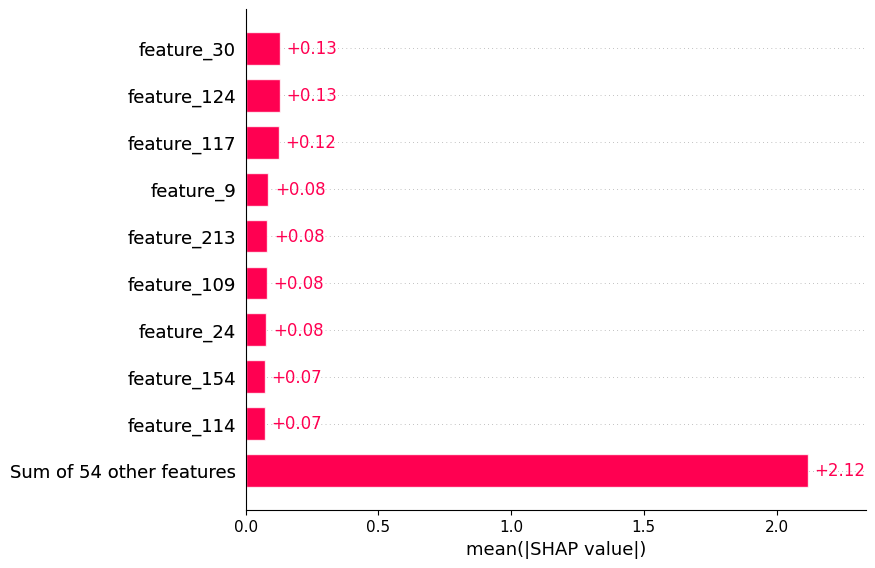

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
shap.summary_plot(shap_values, X_train)

тут у меня уже была готовая функция

In [ ]:
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'shap_importance': np.abs(shap_values.values).mean(axis=0)
})
# Сортируем по убыванию важности
shap_importance = shap_importance.sort_values('shap_importance', ascending=False)

# Получаем топ-40
top_40_features = shap_importance.head(40)
print("Топ-40 признаков по SHAP важности:")
print(top_40_features[['feature', 'shap_importance']])

Топ-40 признаков по SHAP важности:
        feature  shap_importance
3    feature_30         0.129633
1   feature_124         0.128546
2   feature_117         0.124108
43    feature_9         0.084960
44  feature_213         0.081503
8   feature_109         0.079052
18   feature_24         0.078153
50  feature_154         0.072544
4   feature_114         0.071144
19  feature_162         0.070738
25  feature_140         0.069216
7    feature_98         0.068732
6   feature_227         0.061940
37  feature_132         0.060853
27  feature_139         0.059251
17  feature_225         0.059057
16   feature_76         0.057778
31   feature_38         0.057301
55  feature_144         0.056194
53    feature_5         0.055925
29  feature_111         0.054362
24   feature_75         0.053879
11   feature_46         0.053667
0    feature_44         0.050694
13   feature_15         0.047820
14   feature_79         0.047095
59   feature_10         0.045459
54  feature_209         0.044826
28  feat

Анализ 95% вклада признаков:
--------------------------------------------------
Для достижения 95% вклада необходимо 54 признаков из 63
Достигнутый процент вклада: 95.12%
Экономия признаков: 9 (14.3% от общего числа)

Список признаков для 95% вклада:
  1. feature_30
  2. feature_124
  3. feature_117
  4. feature_9
  5. feature_213
  6. feature_109
  7. feature_24
  8. feature_154
  9. feature_114
 10. feature_162
 11. feature_140
 12. feature_98
 13. feature_227
 14. feature_132
 15. feature_139
 16. feature_225
 17. feature_76
 18. feature_38
 19. feature_144
 20. feature_5
 21. feature_111
 22. feature_75
 23. feature_46
 24. feature_44
 25. feature_15
 26. feature_79
 27. feature_10
 28. feature_209
 29. feature_164
 30. feature_56
 31. feature_183
 32. feature_206
 33. feature_26
 34. feature_43
 35. feature_96
 36. feature_115
 37. feature_12
 38. feature_155
 39. feature_142
 40. feature_223
 41. feature_97
 42. feature_167
 43. feature_165
 44. feature_27
 45. feature_2
 46. fea

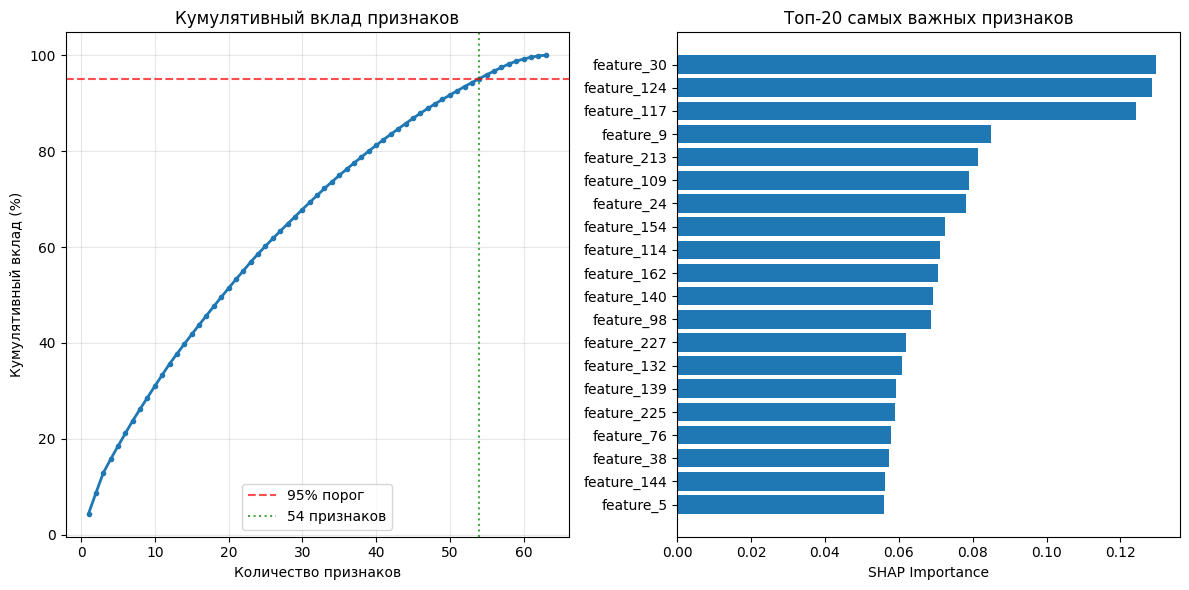

In [ ]:
def get_features_for_percent_contribution(shap_importance_df, target_percent=95):
    """
    Находит минимальное количество признаков, обеспечивающих target_percent% вклада

    Parameters:
    -----------
    shap_importance_df : pandas DataFrame
        DataFrame с колонками 'feature' и 'shap_importance'
    target_percent : float
        Целевой процент вклада (по умолчанию 90)

    Returns:
    --------
    tuple: (features_list, cumulative_percent, num_features)
        - features_list: список признаков
        - cumulative_percent: достигнутый процент вклада
        - num_features: количество признаков
    """
    # Сортируем по убыванию важности (на всякий случай)
    sorted_df = shap_importance_df.sort_values('shap_importance', ascending=False).copy()

    # Вычисляем абсолютные значения и общую сумму
    total_importance = sorted_df['shap_importance'].sum()

    # Вычисляем кумулятивную важность и процент
    sorted_df['cumulative_importance'] = sorted_df['shap_importance'].cumsum()
    sorted_df['cumulative_percent'] = (sorted_df['cumulative_importance'] / total_importance * 100)

    # Находим строку, где достигается целевой процент
    mask = sorted_df['cumulative_percent'] >= target_percent
    selected_features = sorted_df[mask]

    if len(selected_features) > 0:
        # Берем первую строку, где достигнут целевой процент
        first_row_above_threshold = selected_features.iloc[0]
        num_features_needed = sorted_df.index.get_loc(first_row_above_threshold.name) + 1

        # Получаем список признаков
        features_list = sorted_df.iloc[:num_features_needed]['feature'].tolist()
        cumulative_percent = first_row_above_threshold['cumulative_percent']

        # Выводим информацию
        print(f"Для достижения {target_percent}% вклада необходимо {num_features_needed} признаков из {len(shap_importance_df)}")
        print(f"Достигнутый процент вклада: {cumulative_percent:.2f}%")
        print(f"Экономия признаков: {len(shap_importance_df) - num_features_needed} ({((len(shap_importance_df) - num_features_needed)/len(shap_importance_df)*100):.1f}% от общего числа)")

        return features_list, cumulative_percent, num_features_needed
    else:
        print(f"Не удалось достичь {target_percent}% даже со всеми признаками")
        return sorted_df['feature'].tolist(), 100, len(shap_importance_df)


# Дополнительная функция для визуализации
def plot_cumulative_importance(shap_importance_df, target_percent=90):
    """
    Визуализирует кумулятивную важность признаков
    """
    import matplotlib.pyplot as plt

    # Сортируем по убыванию важности
    sorted_df = shap_importance_df.sort_values('shap_importance', ascending=False).copy()
    total_importance = sorted_df['shap_importance'].sum()

    # Вычисляем кумулятивный процент
    cumulative_percent = (sorted_df['shap_importance'].cumsum() / total_importance * 100)

    # Создаем график
    plt.figure(figsize=(12, 6))

    # График кумулятивного процента
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cumulative_percent) + 1), cumulative_percent.values,
             marker='o', markersize=3, linewidth=2)
    plt.axhline(y=target_percent, color='r', linestyle='--', alpha=0.7,
                label=f'{target_percent}% порог')
    plt.xlabel('Количество признаков')
    plt.ylabel('Кумулятивный вклад (%)')
    plt.title('Кумулятивный вклад признаков')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Находим точку, где достигается целевой процент
    mask = cumulative_percent >= target_percent
    if mask.any():
        idx = mask[mask].index[0]
        num_features = sorted_df.index.get_loc(idx) + 1
        plt.axvline(x=num_features, color='g', linestyle=':', alpha=0.7,
                   label=f'{num_features} признаков')
        plt.legend()

    # Гистограмма важности первых N признаков
    plt.subplot(1, 2, 2)
    top_n = min(20, len(sorted_df))
    plt.barh(range(top_n), sorted_df['shap_importance'].values[:top_n][::-1])
    plt.yticks(range(top_n), sorted_df['feature'].values[:top_n][::-1])
    plt.xlabel('SHAP Importance')
    plt.title(f'Топ-{top_n} самых важных признаков')
    plt.tight_layout()
    plt.show()


# Использование функции для вашего случая:
print("Анализ 95% вклада признаков:")
print("-" * 50)

# Получаем признаки для 90% вклада
features_95, cum_percent, num_features = get_features_for_percent_contribution(shap_importance, target_percent=95)

print("\nСписок признаков для 95% вклада:")
for i, feature in enumerate(features_95, 1):
    print(f"{i:3d}. {feature}")

# Визуализация
plot_cumulative_importance(shap_importance, target_percent=95)

In [ ]:
clf = LGBMClassifier(**best_params)
clf.fit(X_train[features_95], y_train) 

preds_test = clf.predict_proba(X_test[features_95])[:, 1]
auc_test_shap = roc_auc_score(y_true=y_test, y_score=preds_test)
print(auc_test_shap)

0.7261283126515741


Для достижения 80% вклада необходимо 39 признаков из 63
Достигнутый процент вклада: 80.01%
Экономия признаков: 24 (38.1% от общего числа)


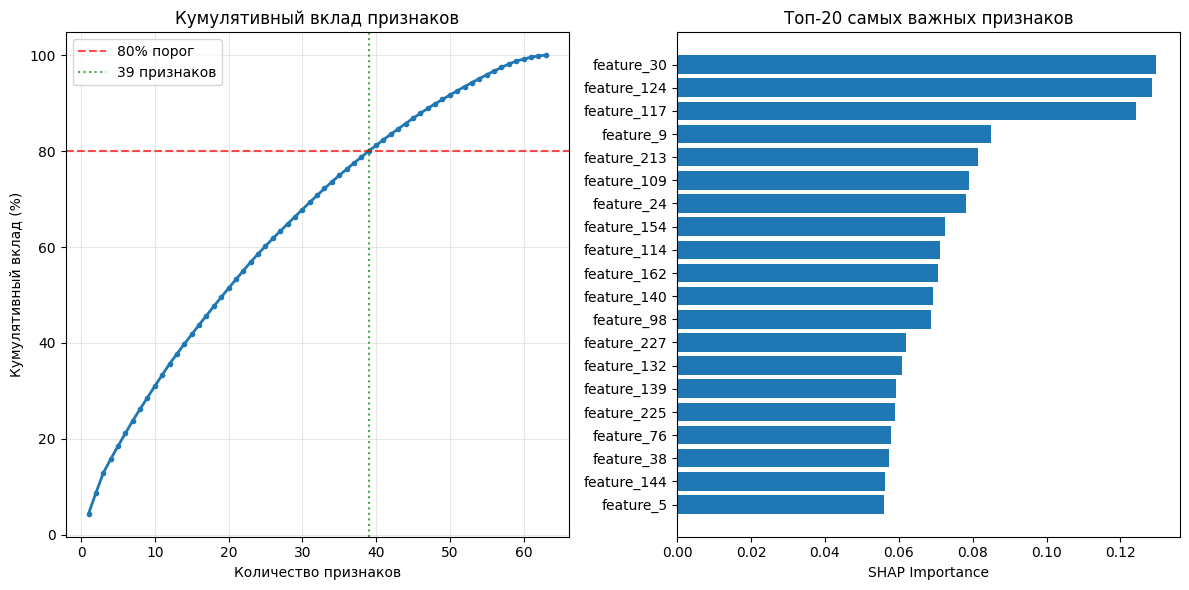

0.7098810802193528


In [ ]:
features_80, cum_percent, num_features = get_features_for_percent_contribution(shap_importance, target_percent=80)


# Визуализация
plot_cumulative_importance(shap_importance, target_percent=80)

clf = LGBMClassifier(**best_params)
clf.fit(X_train[features_80], y_train) 
preds_test = clf.predict_proba(X_test[features_80])[:, 1]
auc_test_shap = roc_auc_score(y_true=y_test, y_score=preds_test)
print(auc_test_shap)

тоже как вариант получается

36 фич с RFE оставил

In [ ]:
def objective(trial):
    params = {
    'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, log=True),  
    'num_leaves': trial.suggest_int('num_leaves', 30, 50),  
    'max_depth': trial.suggest_int('max_depth', 6, 8),  
    'subsample': trial.suggest_float('subsample', 0.8, 1.0),
    'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True),  
    'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True),  
    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
    'random_state': 42
}
    
    clf = LGBMClassifier(**params)
    clf.fit(
        X=X_train[top_features_rfe],
        y=y_train
    )
# тут я тоже проверял на тесте, а не на валидации!

    preds = clf.predict_proba(X_test[top_features_rfe])[:, 1]
    auc_valid = roc_auc_score(
        y_true=y_test,
        y_score=preds
    )
    
    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2026-02-07 23:07:36,663] A new study created in memory with name: no-name-2f85e11c-dd2d-4c08-8fa5-02352c2d69e4
[I 2026-02-07 23:07:40,945] Trial 0 finished with value: 0.7121953768809798 and parameters: {'learning_rate': 0.05980987532277953, 'num_leaves': 46, 'max_depth': 7, 'subsample': 0.9342962551573486, 'reg_alpha': 0.012637641648200335, 'reg_lambda': 0.03289809603115391, 'n_estimators': 267}. Best is trial 0 with value: 0.7121953768809798.
[I 2026-02-07 23:07:42,900] Trial 1 finished with value: 0.7033663263446851 and parameters: {'learning_rate': 0.08083005502027697, 'num_leaves': 48, 'max_depth': 6, 'subsample': 0.9193844399059731, 'reg_alpha': 0.3133639016744506, 'reg_lambda': 0.005187397743467186, 'n_estimators': 126}. Best is trial 0 with value: 0.7121953768809798.
[I 2026-02-07 23:07:44,700] Trial 2 finished with value: 0.7081676391235499 and parameters: {'learning_rate': 0.14659170217437445, 'num_leaves': 41, 'max_depth': 6, 'subsample': 0.867736897207931, 'reg_alpha': 0

In [ ]:
best_params = study.best_params
best_auc = study.best_value

print('Best params: ', best_params)
print('Best AUC: ', best_auc)

Best params:  {'learning_rate': 0.0934522498921934, 'num_leaves': 47, 'max_depth': 6, 'subsample': 0.9369449794419984, 'reg_alpha': 0.001140571857733334, 'reg_lambda': 0.2954317065402056, 'n_estimators': 500}
Best AUC:  0.7188847877806748
